# Test whether including old data improves performance

We have data from 1963-1997, but only at hourly frequency (whereas the competition data is a 1-minute frequency). This notebook tests whether an hourly model using all the data is better than a high-frequency model trained only on the recent data.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from model_definitions import (define_model_cnn_1_min, define_model_cnn_hourly, define_model_lstm_1_min, define_model_lstm_hourly)
from preprocessing import combine_old_and_new_data
from predict import load_models, predict_batch
from train import train_nn_models
import time
from typing import Callable, Tuple
import tensorflow as tf
from plotting import plot_binned_RMSE
import matplotlib.pyplot as plt


In [2]:
# download and save data
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
# !unzip public.zip
# !wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
# !unzip private.zip
# !mkdir data
# !mv public data
# !mv private data

In [3]:
# user options
retrain_models = True # if true, train and save models, otherwise load pre-trained models from disk
model = "lstm"
if model == "cnn":
    model_name_1_min = "cnn_1_min"
    model_def_1_min = define_model_cnn_1_min
    model_name_hourly = "cnn_hourly"
    model_def_hourly = define_model_cnn_hourly
elif model == "lstm":
    model_name_1_min = "lstm_1_min"
    model_def_1_min = define_model_lstm_1_min
    model_name_hourly = "lstm_hourly"
    model_def_hourly = define_model_lstm_hourly

In [4]:
# load recent data
data_folder = "data"
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"))
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"))
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"))
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"))
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"))
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"))

In [5]:
# train 1-minute model
output_folder = os.path.join("trained_models", model_name_1_min, "benchmark")
os.makedirs(output_folder, exist_ok=True)
if retrain_models:
    train_nn_models(solar_train, sunspots_train, dst_train, model_def_1_min, 1, output_folder, "minute", early_stopping=True)

Epoch 1/100
3469/3469 [==============================] - 76s 20ms/step - loss: 144.1707 - root_mean_squared_error: 11.8487 - val_loss: 87.9370 - val_root_mean_squared_error: 9.3775
Epoch 2/100
3469/3469 [==============================] - 70s 20ms/step - loss: 70.0388 - root_mean_squared_error: 8.3668 - val_loss: 85.5548 - val_root_mean_squared_error: 9.2496
Epoch 3/100
3469/3469 [==============================] - 70s 20ms/step - loss: 52.6801 - root_mean_squared_error: 7.2571 - val_loss: 73.6410 - val_root_mean_squared_error: 8.5814
Epoch 4/100
3469/3469 [==============================] - 70s 20ms/step - loss: 43.4409 - root_mean_squared_error: 6.5905 - val_loss: 81.7985 - val_root_mean_squared_error: 9.0443
Epoch 5/100
3469/3469 [==============================] - 70s 20ms/step - loss: 38.6893 - root_mean_squared_error: 6.2199 - val_loss: 81.2273 - val_root_mean_squared_error: 9.0126
Epoch 6/100
3469/3469 [==============================] - 70s 20ms/step - loss: 35.2621 - root_mean_squa

In [6]:
# Load older data
solar_old = pd.read_csv(os.path.join(data_folder, "old", "solar_wind.csv"))
dst_old = pd.read_csv(os.path.join(data_folder, "old", "dst_labels.csv"))
sunspots_old = pd.read_csv(os.path.join(data_folder, "old", "sunspots.csv"))
# Merge data - train on old and recent public data, test on recent private data
solar_train_hourly = combine_old_and_new_data(solar_old, solar_train)
sunspots_train_hourly = pd.concat([sunspots_train, sunspots_old], axis=0)
dst_train_hourly = pd.concat([dst_train, dst_old], axis=0)
solar_test_hourly = solar_test.copy()
# Extract hourly data
solar_test_hourly = combine_old_and_new_data(pd.DataFrame(), solar_test)

In [7]:
# train hourly model
output_folder = os.path.join("trained_models", model_name_hourly, "benchmark")
os.makedirs(output_folder, exist_ok=True)
if retrain_models:
    train_nn_models(solar_train_hourly, sunspots_train_hourly, dst_train_hourly, model_def_hourly, 1, output_folder, "hour", early_stopping=True)

Epoch 1/100
1367/1367 [==============================] - 122s 87ms/step - loss: 266.9869 - root_mean_squared_error: 16.2715 - val_loss: 246.8603 - val_root_mean_squared_error: 15.7118
Epoch 2/100
1367/1367 [==============================] - 117s 86ms/step - loss: 163.5993 - root_mean_squared_error: 12.7877 - val_loss: 248.2560 - val_root_mean_squared_error: 15.7561
Epoch 3/100
1367/1367 [==============================] - 117s 86ms/step - loss: 123.3942 - root_mean_squared_error: 11.1055 - val_loss: 252.3950 - val_root_mean_squared_error: 15.8869
Epoch 4/100
1367/1367 [==============================] - 117s 86ms/step - loss: 89.8976 - root_mean_squared_error: 9.4805 - val_loss: 274.5232 - val_root_mean_squared_error: 16.5687
Epoch 5/100
1367/1367 [==============================] - 118s 86ms/step - loss: 72.2795 - root_mean_squared_error: 8.5015 - val_loss: 268.0573 - val_root_mean_squared_error: 16.3725
Epoch 6/100
1367/1367 [==============================] - 111s 79ms/step - loss: 273.

In [8]:
# measure performance - 1 minute model
output_folder = os.path.join("trained_models", model_name_1_min, "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
predictions = predict_batch(
    solar_test.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "minute"
)
dst_test_1_min = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_1_min["dst_t_plus_1"] = dst_test_1_min.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test_1_min["dst"].values, dst_test_1_min["prediction_t"].values)
)
valid_ind = dst_test_1_min["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_1_min.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_1_min.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")


RMSE for time t: 13.24
RMSE for time t+1: 14.36


In [14]:
# measure performance - hourly model
output_folder = os.path.join("trained_models", model_name_hourly, "benchmark")
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()
predictions = predict_batch(
    solar_test_hourly.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "hour"
)
dst_test_hourly = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_hourly["dst_t_plus_1"] = dst_test_hourly.groupby("period")["dst"].shift(-1)
loss_t = np.sqrt(
    mean_squared_error(dst_test_hourly["dst"].values, dst_test_hourly["prediction_t"].values)
)
valid_ind = dst_test_hourly["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_hourly.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_hourly.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 13.77
RMSE for time t+1: 14.62


In [15]:
# blend the two models
dst_test_blend = dst_test_hourly.copy()
hourly_weight = 0.5
dst_test_blend["prediction_t"] = dst_test_hourly["prediction_t"] * hourly_weight + dst_test_1_min["prediction_t"] * (1 - hourly_weight)
dst_test_blend["prediction_t_plus_1"] = dst_test_hourly["prediction_t_plus_1"] * hourly_weight + dst_test_1_min["prediction_t_plus_1"] * (1 - hourly_weight)

loss_t = np.sqrt(
    mean_squared_error(dst_test_blend["dst"].values, dst_test_blend["prediction_t"].values)
)
valid_ind = dst_test_blend["dst_t_plus_1"].notnull()
loss_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_blend.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_blend.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)

print(f"RMSE for time t: {loss_t:0.2f}")
print(f"RMSE for time t+1: {loss_t_plus_1:0.2f}")

RMSE for time t: 12.28
RMSE for time t+1: 13.40


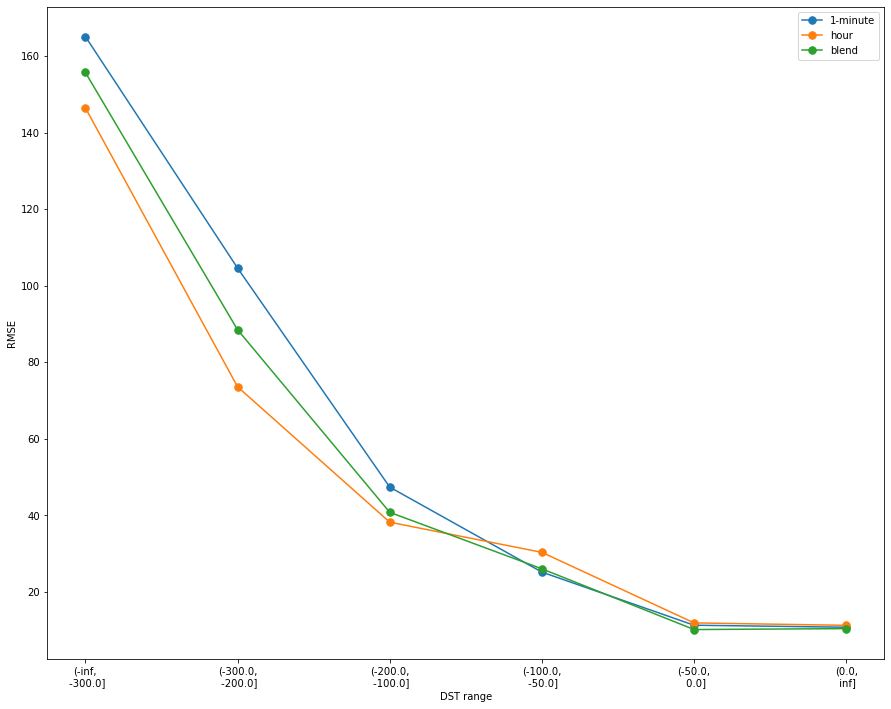

In [16]:
# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test_1_min.loc[valid_ind, "dst"].values, dst_test_1_min.loc[valid_ind, "prediction_t"].values, bins)
plot_binned_RMSE(dst_test_hourly.loc[valid_ind, "dst"].values, dst_test_hourly.loc[valid_ind, "prediction_t"].values, bins)
plot_binned_RMSE(dst_test_blend.loc[valid_ind, "dst"].values, dst_test_blend.loc[valid_ind, "prediction_t"].values, bins)
plt.legend(["1-minute", "hour", "blend"])

In [17]:
# size of ranges
bin_id = pd.cut(dst_test_1_min.loc[valid_ind, "dst"], bins).to_frame("bin")
bin_id.groupby("bin").size().to_frame("size")

,size
bin,
"(-inf, -300.0]",17
"(-300.0, -200.0]",33
"(-200.0, -100.0]",436
"(-100.0, -50.0]",2516
"(-50.0, 0.0]",43218
"(0.0, inf]",12454


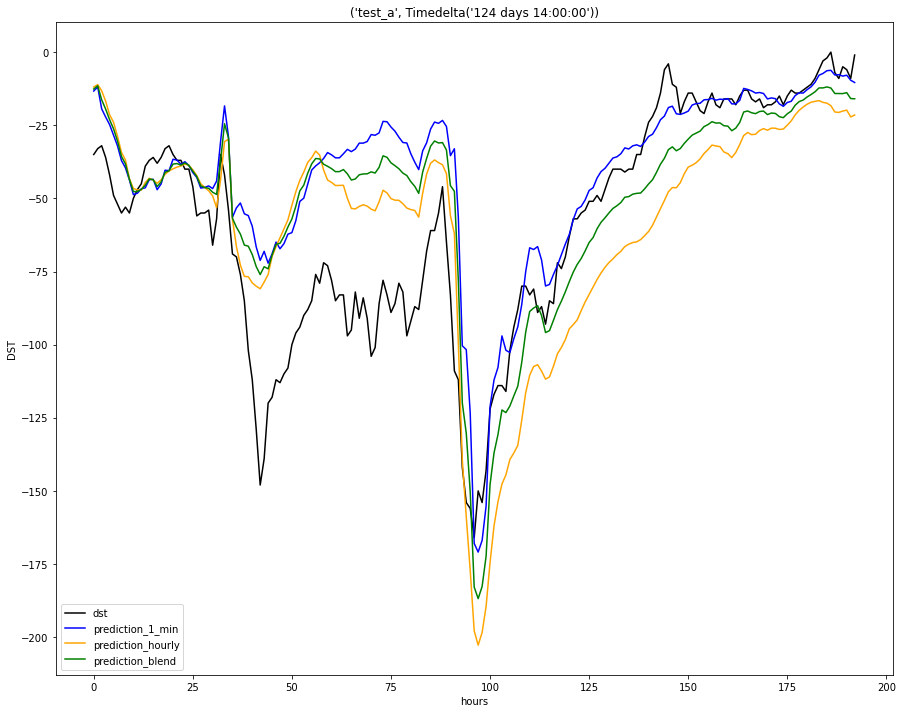

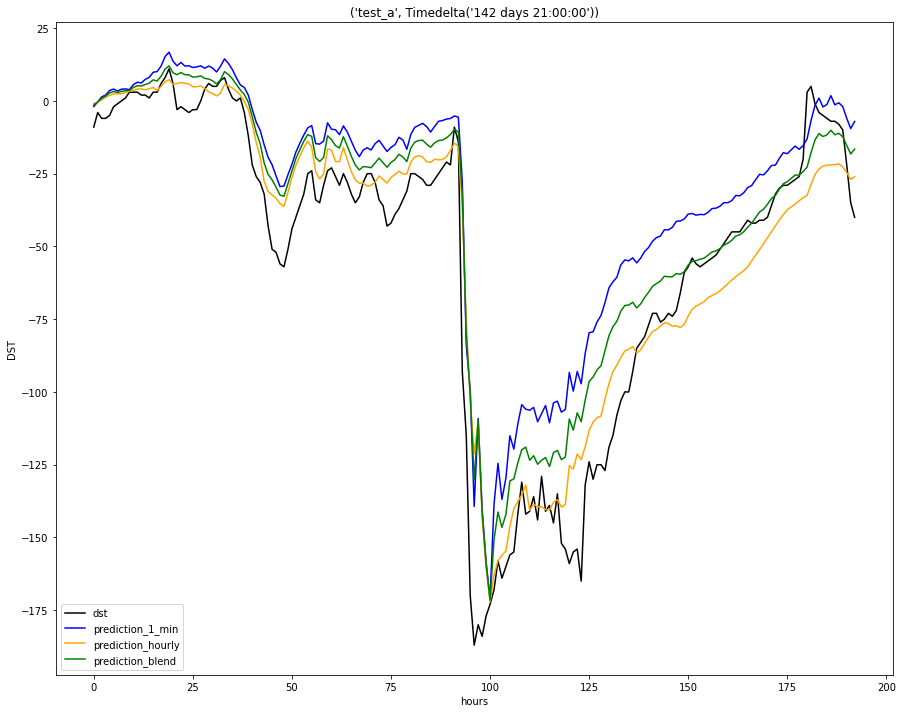

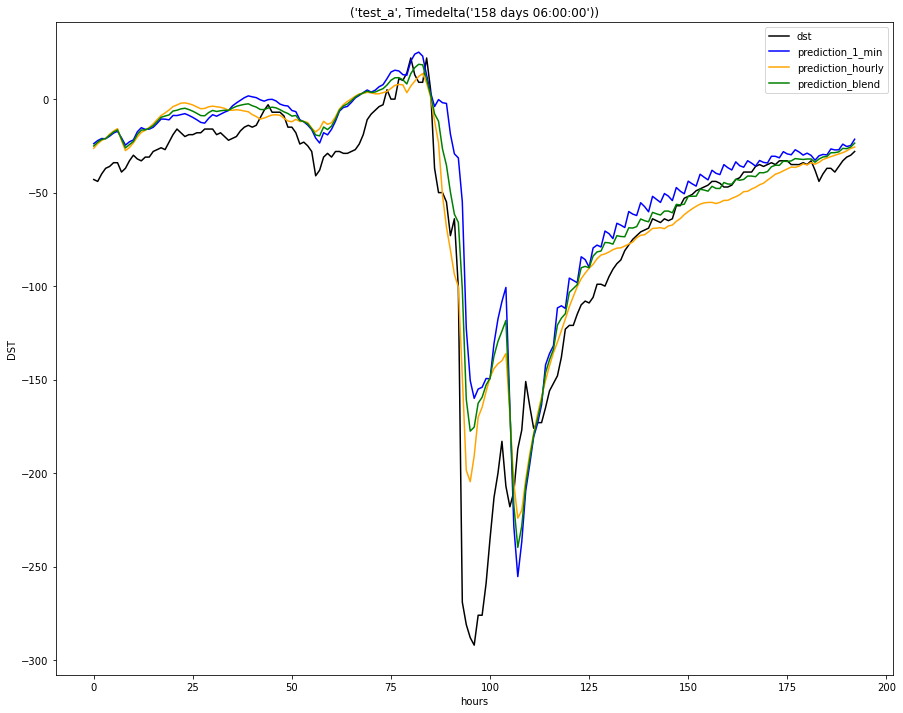

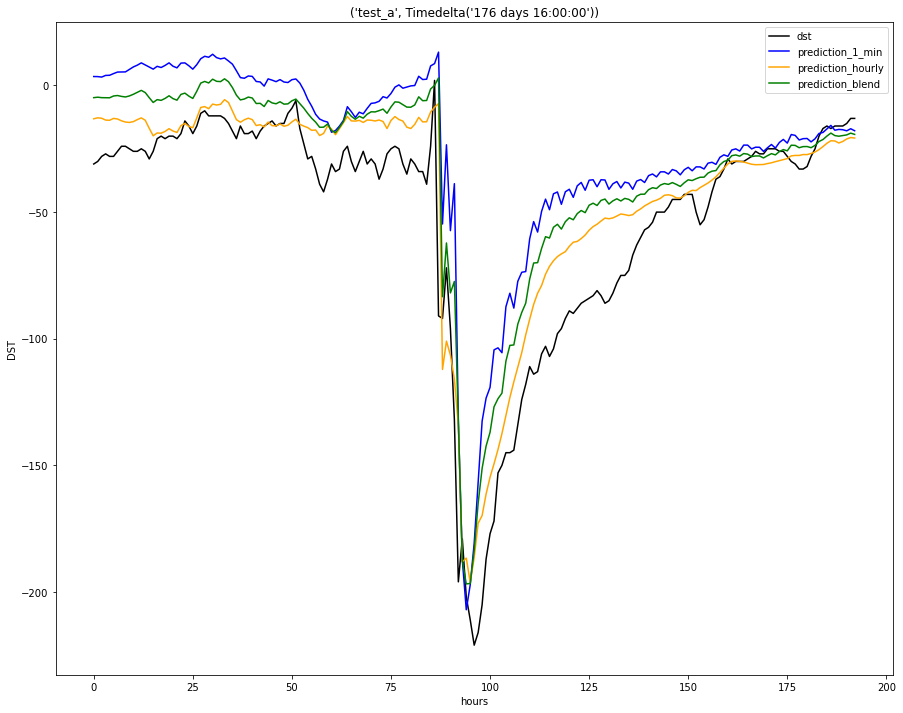

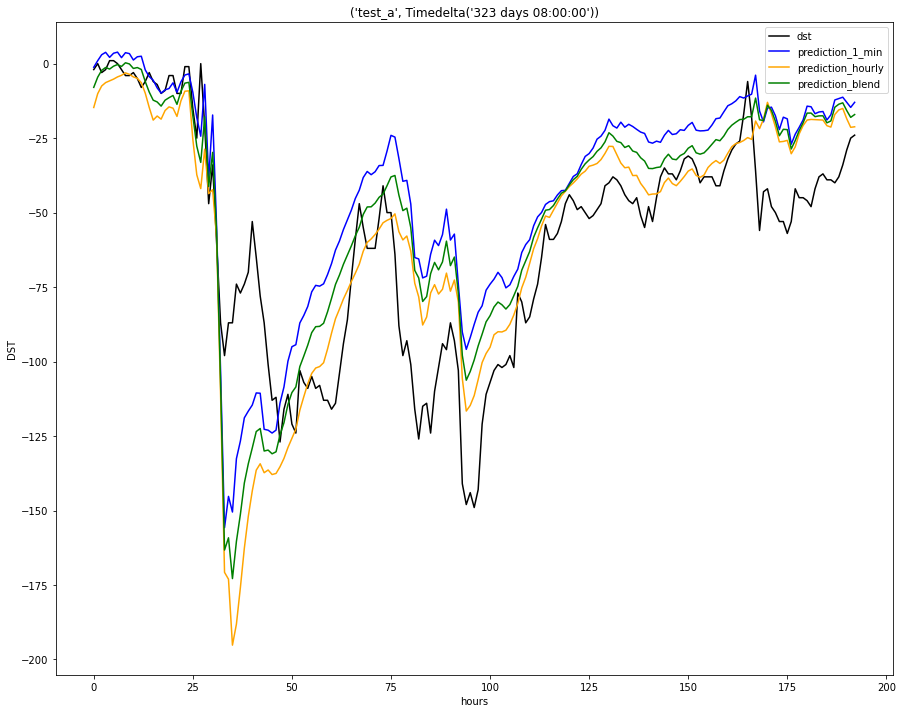

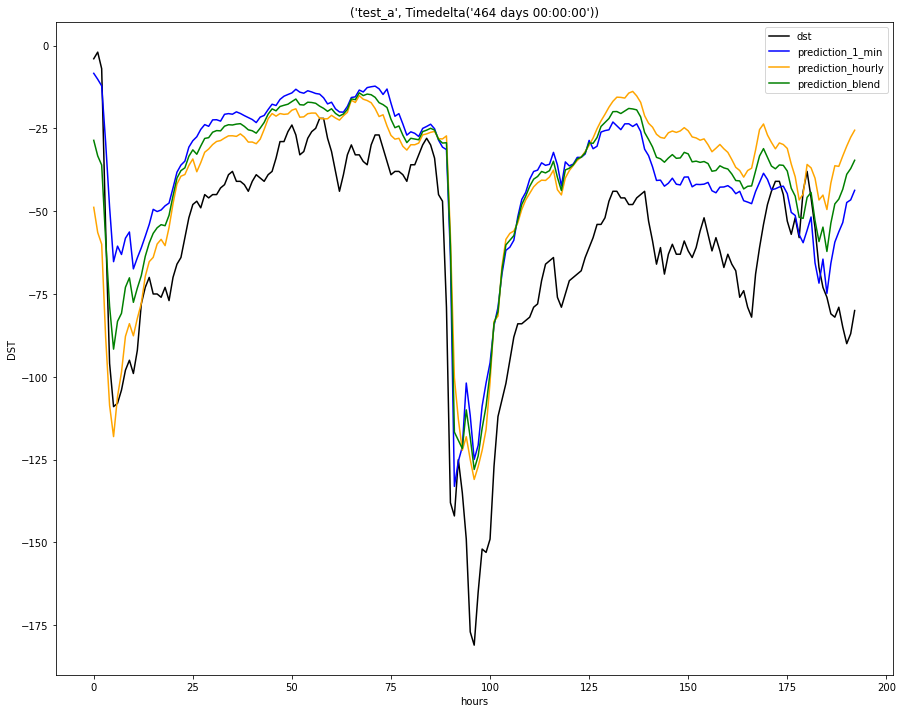

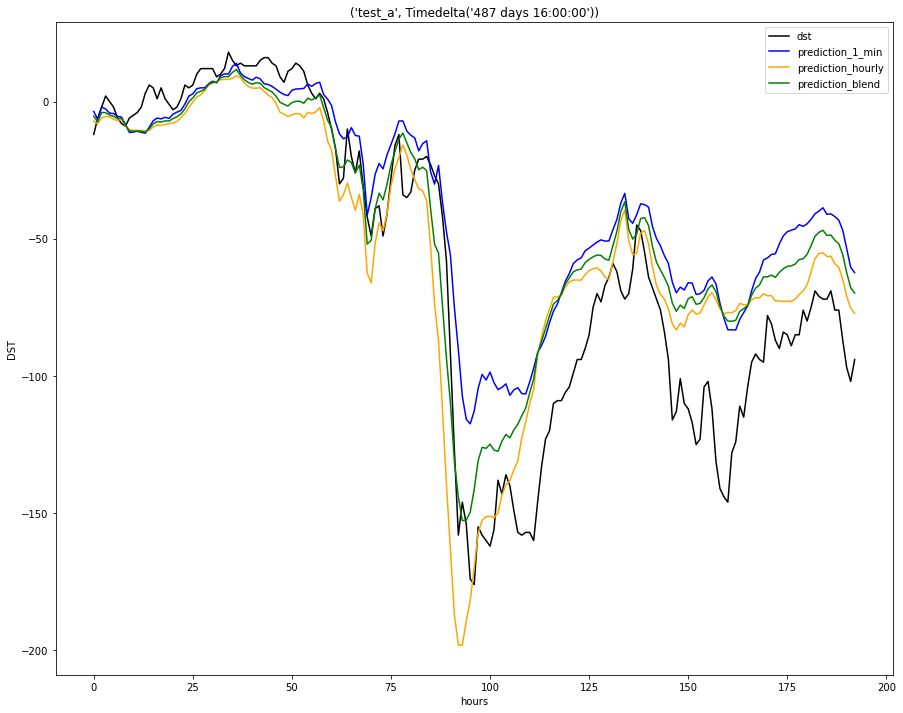

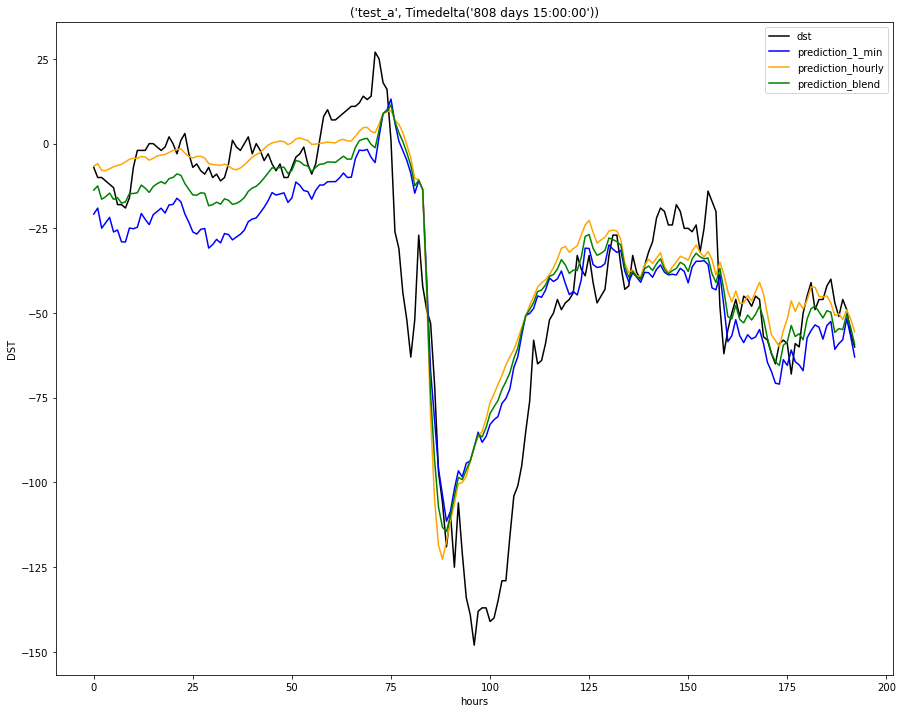

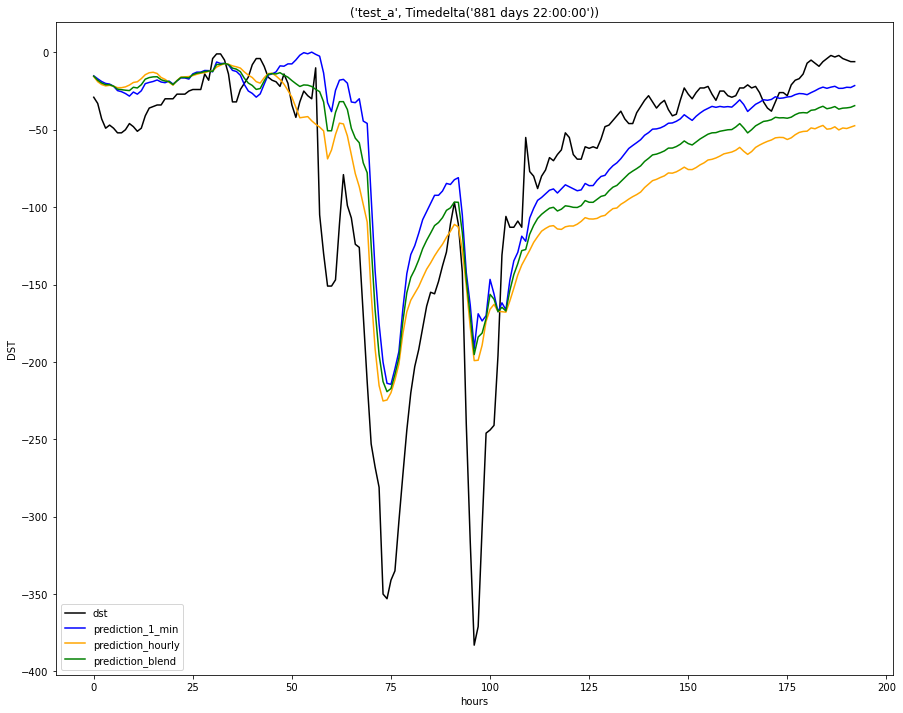

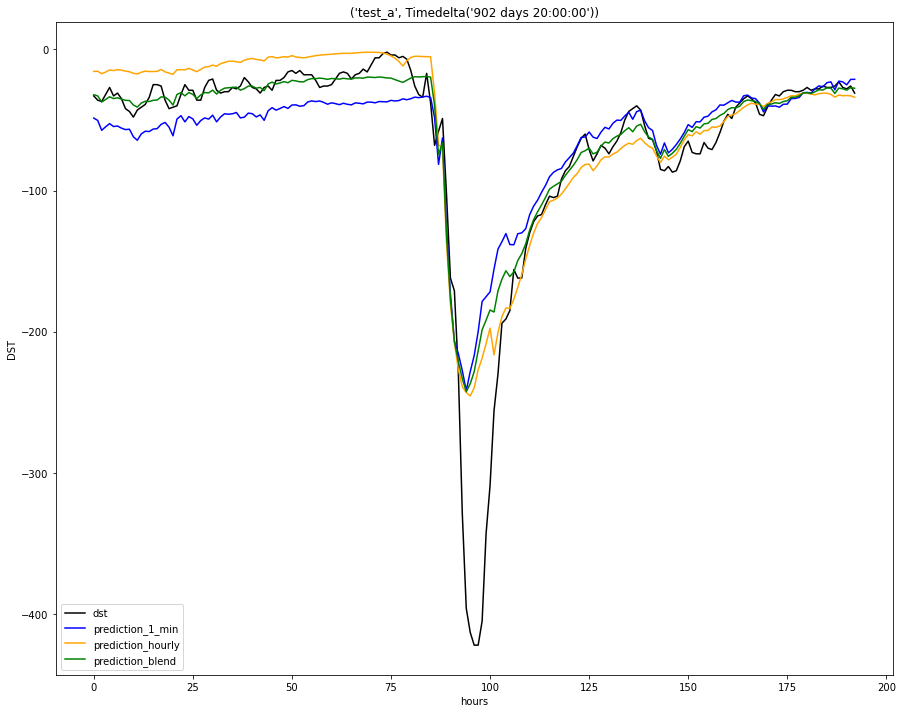

In [18]:
# plot forecast vs actual at storm events
# select events at least 7 days apart
num_events = 10
min_ind_arr = []
min_time_arr = []
labels = []
# dst
dst_test['exclude'] = False
for i in range(num_events):
    min_ind = dst_test.loc[~dst_test['exclude'], 'dst'].idxmin()
    min_time = dst_test.loc[min_ind, ['timedelta', 'period']]
    min_time_arr.append(min_time)
    t, p = min_time['timedelta'], min_time['period']
    min_ind_arr.append(min_ind)
    labels.append(f"{min_time['period'], min_time['timedelta']}")
    dst_test['exclude'] = dst_test['exclude'] | (((dst_test['timedelta'] - t).dt.total_seconds().abs() <= 7 * 24 * 3600) & (dst_test['period'] == p))

# sort by period and timedelta
sort_ind = list(range(num_events))
sort_ind = sorted(sort_ind, key=lambda x: (min_time_arr[x]['period'], min_time_arr[x]['timedelta']))
min_ind_arr = [min_ind_arr[i] for i in sort_ind]
labels = [labels[i] for i in sort_ind]


for i in range(num_events):
    # extract 96 hours before and after max
    ind = min_ind_arr[i]
    # centre on min within 96 * 2 hour window
    new_min = dst_test.loc[ind - 96: ind + 96, 'dst'].idxmin()
    df = dst_test.loc[new_min - 96: new_min + 96].copy()
    df = pd.merge(df, dst_test_1_min[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    df.rename(columns={"prediction_t": "prediction_1_min"}, inplace=True)
    df = pd.merge(df, dst_test_hourly[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    df.rename(columns={"prediction_t": "prediction_hourly"}, inplace=True)
    df = pd.merge(df, dst_test_blend[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    df.rename(columns={"prediction_t": "prediction_blend"}, inplace=True)
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_1_min"].values, c="blue")
    plt.plot(df["prediction_hourly"].values, c="orange")
    plt.plot(df["prediction_blend"].values, c="green")
    plt.legend(["dst", "prediction_1_min", "prediction_hourly", "prediction_blend"])
    plt.title(labels[i])
    plt.xlabel("hours")
    plt.ylabel("DST")

